<a href="https://colab.research.google.com/github/jumping2000/Quants/blob/main/inflation_analysis/inflation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analisi sull'effetto dell'inflazione sui rendimenti finanziari
* Verifica degli andamenti dell'inflazione in EU e US
* Calcolo dei rendimenti aggiustati all'inflazione negli ultimi 20 anni
* Calcolo rendimenti rolling a 5 e 10 anni aggiustati all'inflazione

## Bibliografia
*  https://medium.com/@lucamingarelli/easy-access-to-ecb-data-in-python-6015b65dcc0e
* https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-data-with-python-9d69a8dcbc27
*  https://data.ecb.europa.eu/
*  https://www.investopedia.com/terms/i/inflation_adjusted_return.asp
*  https://pieriantraining.com/exploring-inflation-data-with-python/
*  https://www.franklintempleton.co.uk/articles/2023/brandywine-global/deconstructing-the-dynamic-duo-of-stocks-and-bonds

In [ ]:
!pip install ecbdata cpi
from ecbdata import ecbdata
import cpi
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 38.1 MB/s eta 0:00:00


<ipython-input-1-6cb6efcfebf9>:3: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  import cpi


In [ ]:
cpi.update()

/usr/local/lib/python3.10/dist-packages/cpi/download.py:175: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")


### Inserisci i dati utili

In [ ]:
start_date = '1990-01-01'
end_date = '2024-09-01'
eur_data = False # False se utilizzo i dati di inflazione americani, true se uso inflaizone Europea
confronto_inflazione = False #  True se scarico entrambi i dati di inflazione e li visualizzo, se False scarico dati inflazione US


## Scarico dati da Yahoo Finance

In [ ]:
#stocks=[["SP500","SPY"], ["SPDR Gold Shares","GLD"]] #,["iShares 7-10 Year Treasury Bonds","IEF"]] # ["Core S&P 500","CSSPX.MI"],["Ishares MSCI World","SWDA.MI"]]
#stocks = [["Ishares MSCI World","SWDA.MI"],["Invesco Phisycal Gold","SGLD.MI"]]
stocks = [["S&P500","^GSPC"]] #, ["Treasury Yeld 10 Years","^TNX"] ]
# DATI INIZIALI
nomi=list(np.array(stocks)[:,0])
tickers=list(np.array(stocks)[:,1])
pesi_percentuali = np.array([0.5, 0.5])

# SCARICO DA YAHOO
ticker = ''
if len(tickers) == 1:
    ticker = tickers[0]
    dati = yf.download(ticker, start=start_date, end=end_date, interval='1mo')['Adj Close']
    pesi_percentuali = 1
    dati.rename(ticker,inplace=True)
else:
    dati = yf.download(tickers, start=start_date, end=end_date, interval='1mo')['Adj Close']
    dati = dati.reindex(tickers, axis=1)
# Rimuovere le righe con valori mancanti
dati.dropna(inplace=True)
dati.index = dati.index.tz_localize(None)
dati

[*********************100%***********************]  1 of 1 completed


,^GSPC
Date,
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
1990-05-01,361.230011
...,...
2024-04-01,5035.689941
2024-05-01,5277.509766
2024-06-01,5460.479980


## Recupero dati inflazione europea

In [ ]:
df_inflation = pd.DataFrame()
if confronto_inflazione == True:
    df_inflation = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', start=start_date)
    df_inflation['TIME_PERIOD'] = pd.to_datetime(df_inflation['TIME_PERIOD'])
    df_inflation.set_index('TIME_PERIOD', inplace=True)
    df_inflation.index.names = ['Date']
    df_inflation = df_inflation.rename(columns={'OBS_VALUE': 'EU_Inflation'})
    df_inflation = df_inflation[['EU_Inflation']]/100
    ## SOSTITUSICO 0 con 0.001 per evitare problemi con il calcolo dei ritorni inflation adjusted
    df_inflation.replace(0.0, 0.001, inplace=True)
    df_inflation


In [ ]:
if confronto_inflazione == True:
    fig = plt.figure()
    df_inflation['EU_Inflation'].plot(figsize=(18,6))
    plt.axhline(0.02,ls='--',c='red')
    plt.axhline(0.00,ls='-.',c='black')
    plt.xlabel('Date')
    plt.ylabel('YoY % Change')
    plt.title('EU Inflation');

## Recupero dati inflazione americana

In [ ]:
cpi_items_df = cpi.series.get(seasonally_adjusted=False).to_dataframe()
cpi_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   series_id            1451 non-null   object 
 1   year                 1451 non-null   int64  
 2   date                 1451 non-null   object 
 3   value                1451 non-null   float64
 4   period_id            1451 non-null   object 
 5   period_code          1451 non-null   object 
 6   period_abbreviation  1451 non-null   object 
 7   period_name          1451 non-null   object 
 8   period_month         1451 non-null   int64  
 9   period_type          1451 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 113.5+ KB


In [ ]:
cpi_items_df = cpi_items_df[cpi_items_df['period_type']=='monthly']
cpi_items_df['date'] = pd.to_datetime(cpi_items_df['date'])
cpi_items_df = cpi_items_df.set_index('date')
cpi_items_df.sort_index(inplace=True)

<ipython-input-8-1ad20dc0b0ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_items_df['date'] = pd.to_datetime(cpi_items_df['date'])


In [ ]:
a = datetime.strptime(start_date, '%Y-%m-%d')
start_date = str(a - relativedelta(years = 1))
cpi_items_df = cpi_items_df.loc[start_date:end_date]
#cpi_items_df

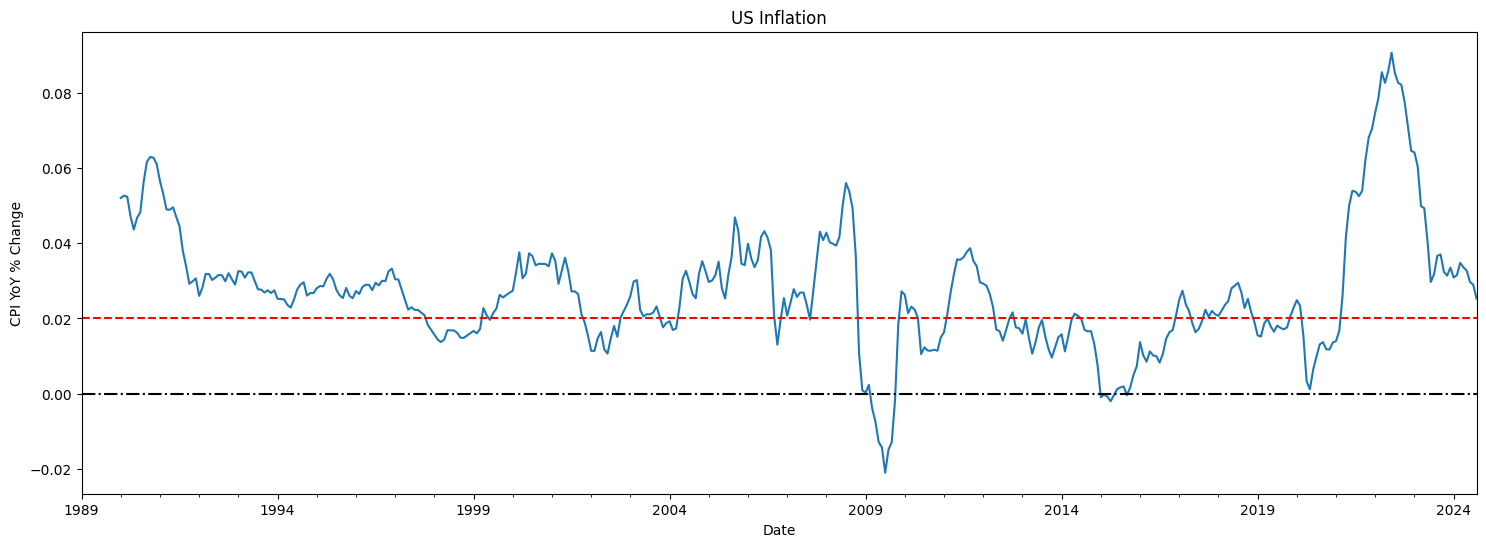

In [ ]:
fig = plt.figure()
cpi_items_df['value'].pct_change(12).plot(figsize=(18,6))
plt.axhline(0.02,ls='--',c='red')
plt.axhline(0.00,ls='-.',c='black')
plt.xlabel('Date')
plt.ylabel('CPI YoY % Change');
plt.title('US Inflation');

In [ ]:
if confronto_inflazione == True:
    df_inflation.insert(1, 'US_Inflation', cpi_items_df['value'].pct_change(12))
else:
    df_inflation['US_Inflation'] = cpi_items_df['value'].pct_change(12)
df_inflation.dropna(inplace=True)


In [ ]:
df_inflation.index = df_inflation.index.tz_localize(None)
df_inflation

,US_Inflation
date,
1990-01-01,0.052023
1990-02-01,0.052632
1990-03-01,0.052330
1990-04-01,0.047116
1990-05-01,0.043619
...,...
2024-04-01,0.033574
2024-05-01,0.032690
2024-06-01,0.029714


In [ ]:
if confronto_inflazione == True:
    fig = px.line(
        data_frame=df_inflation,
        color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
        template="plotly_dark",
        title = 'Inflazione Year over Year  per EU e US'
    )
    fig.update_traces(hovertemplate=None)
    fig.update_layout(
        yaxis_title='Inflation YoY',
        xaxis_title='Date',
        hovermode="x unified",
    )
    fig.add_hline(y=0.02)
    fig.show()


In [ ]:
def get_norm(df):
    return df / df.iloc[0]

fig = px.line(
    data_frame=get_norm(dati),
    color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
    template="plotly_dark",
)
fig.update_traces(hovertemplate=None)
fig.update_layout(
    title='Prezzo Normalizzato degli asset',
    xaxis_title='Date',
    yaxis_title='Price',
    hovermode="x unified",
    # text = ["Date", "Value"],
)
fig.show()

##Formule per i rendimenti
Rendimento annualizzato partendo dai rendimenti mensili:
$$
\text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right)^{\frac{12}{n}} - 1
$$
<br>Formula semplificata (funziona bene se la volatilità dei rendimenti non è eccessiva): <br><br>
$$
\text{Annualized Return} = \left( 1 + MeanReturn \right)^{12} - 1
$$
<br>Per i rendimenti mensili aggiustati all'inflazione:
$$
\text{Return-adjusted}_{monthly} = \dfrac{1 + Return_{monthly}}{1+Inflation_{monthly}} -1
$$

In [ ]:
# Calcola i rendimenti mensili
rendimenti = dati.pct_change().dropna()
# Calcola i rendimenti annualizzati
rendimento_annualizzato = (1 + rendimenti).prod() ** (12 / len(rendimenti)) - 1
print(f'Rendimento annualizzato {rendimento_annualizzato}')

Rendimento annualizzato 0.08567533178133457


In [ ]:
#df_inflation.isnull().values.any()
df_inflation.drop(index=df_inflation.index[0], inplace=True)
# Dividere il tasso di inflazione annuale per 12 per ottenere il tasso di inflazione mensile
df_inflation_month = df_inflation / 12


In [ ]:
# Calcolare i rendimenti aggiustati all'inflazione per ciascun ETF
if eur_data == True:
    rendimenti_adjusted = (1 + rendimenti).div(1 + df_inflation_month['EU_Inflation'], axis=0) - 1
else:
    rendimenti_adjusted = (1 + rendimenti).div(1 + df_inflation_month['US_Inflation'], axis=0) - 1
# Rinominare le colonne per indicare che sono i rendimenti aggiustati all'inflazione
if len(tickers) == 1:
    rendimenti_adjusted.rename(f"{ticker}_adjusted",inplace=True)
else:
    rendimenti_adjusted.columns = [f"{col}_real" for col in rendimenti.columns]
####
rendimento_annualizzato_adjusted = (1 + rendimenti_adjusted).prod() ** (12 / len(rendimenti_adjusted)) - 1
rendimento_annualizzato_adjusted
df_rendimenti = pd.concat([rendimenti, rendimenti_adjusted], axis=1)

In [ ]:
# Calculate the cumulative daily returns (--> in uscita un array)
def cum_total_return(returns):
    return (1 + returns).cumprod() - 1

# Calculate the cumulative monthly returns
rendimentoCumulato = cum_total_return(rendimenti)
print(f'Rendimento cumulato nel peridio di osservazione:\n{rendimentoCumulato.iloc[-1]}')
rendimentoCumulato_adjusted = cum_total_return(rendimenti_adjusted)
print(f'\nRendimento cumulato "inflation adjusted" nel periodo di osservazione:\n{rendimentoCumulato_adjusted.iloc[-1]}')
df_rendimenti_cumulati = pd.concat([rendimentoCumulato, rendimentoCumulato_adjusted], axis=1)
#
#rapporto_rendimenti = [a / b for a, b in zip(rendimentoCumulato.iloc[-1].tolist(), rendimentoCumulato_adjusted.iloc[-1].tolist())]
#print(f'\nRapporto tra i rendimenti:\n{rapporto_rendimenti}')

Rendimento cumulato nel peridio di osservazione:
16.164215791966374

Rendimento cumulato "inflation adjusted" nel periodo di osservazione:
5.767831506577149


In [ ]:
fig = px.line(
    data_frame=df_rendimenti_cumulati,
    color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
    template="plotly_dark",
    title = 'Rendimenti: cumulati vs cumulati "inflation adjusted"'
)
fig.show()

## Analisi rolling

In [ ]:
# Funzione per calcolare il rendimento rolling annualizzato
def rolling_return(returns, window):
    return (1 + returns.rolling(window=window).apply(lambda x: np.prod(1 + x) - 1)).pow(12/window) - 1
YEARS = 5
rolling_return_assets = rolling_return(df_rendimenti, 12*YEARS)

In [ ]:
fig = px.line(
    data_frame=rolling_return_assets,
    color_discrete_sequence=["#636EFA", "#EF553B", "#19D3F3", "#B6E880", "#FECB52", "#2ECB32","#FF6600","#0033CC"],
    template="plotly_dark",
    title = f'Rendimenti Rolling, normali vs "inflation adjusted" a {YEARS} anni'
)
fig.show()

In [ ]:
# Recupero informazioni di cambio Euro / Dollaro
# eur_usd = yf.download('EURUSD=X', start=start_date, end=end_date, interval='1mo')
# eur_usd = eur_usd[['Adj Close']].rename(columns={'Adj Close': 'EUR/USD'})
# eur_usd.ffill(limit=3,inplace=True) ## Riempio i buchi
# eur_usd  = eur_usd.loc[start_date:end_date]
# eur_usd
# #
# #eur_usd.index = pd.to_datetime(eur_usd.index)

# dati.index = dati.index.tz_localize(None)
# eur_usd.index = eur_usd.index.tz_localize(None)
# df_inflation.index = df_inflation.index.tz_localize(None)

# for col in dati.columns:
#     if col+'_EUR' not in dati.columns and '.MI' not in col:
#         dati[col+'_EUR'] = dati[col] * eur_usd['EUR/USD']